## Imports

In [107]:
import numpy as np
import pandas as pd
import re
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from patsy import dmatrices
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
warnings.filterwarnings("ignore")

## Functions

In [108]:
def test_normality(df: pd.DataFrame, cols: list, log=False) -> pd.DataFrame:
    if not log:
        return df[cols].\
    apply(lambda x: np.round(stats.shapiro(x), decimals=3)).\
    T.rename(columns = {0: 'shapiro_stat', 1: 'p_value'})
    else:
        return df[cols].\
    apply(lambda x: np.log(x + 1)).\
    apply(lambda x: np.round(stats.shapiro(x), decimals=3)).T.rename(columns = {0: 'shapiro_stat', 1: 'p_value'})
    
def linear_model(df, x, y, log=False):
    if not log:
        slope, intercept, r_value, p_value, std_err = stats.linregress(df[x], df[y])
    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(df[x] + 1), np.log(df[y] + 1))
    return pd.DataFrame([slope, intercept, r_value, p_value]).\
rename({0: 'slope', 1: 'intercept', 2: 'r_value', 3: 'p_value'}).T

def visualize_residuals(x, y, intercept, slope):
    res_distribution = np.abs(x - intercept + slope * y)
    return sns.distplot(res_distribution)

## Read data

In [109]:
student_perform = pd.read_csv("/home/marina/Загрузки/StudentsPerformance.csv")
student_perform.columns = [re.sub(" |/", "_", x) for x in student_perform.columns]
student_perform.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Replace some categorical variables to "numeric"

In [110]:
le_parental_level_of_education = preprocessing.LabelEncoder()
le_parental_level_of_education.fit(student_perform.parental_level_of_education)
student_perform.parental_level_of_education = le_parental_level_of_education.transform(student_perform.parental_level_of_education)

le_lunch = preprocessing.LabelEncoder()
le_lunch.fit(student_perform.lunch)
student_perform.lunch = le_lunch.transform(student_perform.lunch)

le_race_ethnicity = preprocessing.LabelEncoder()
le_race_ethnicity.fit(student_perform.race_ethnicity)
student_perform.race_ethnicity = le_race_ethnicity.transform(student_perform.race_ethnicity)

In [111]:
student_perform.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,1,1,1,none,72,72,74
1,female,2,4,1,completed,69,90,88
2,female,1,3,1,none,90,95,93
3,male,0,0,0,none,47,57,44
4,male,2,4,1,none,76,78,75


### Visualize target variables (check "linearity")

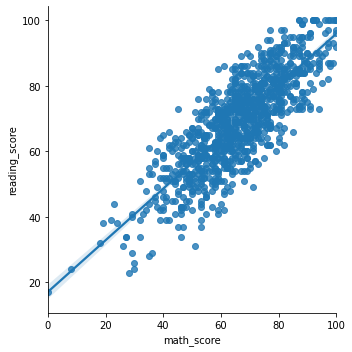

In [112]:
sns.lmplot(x='math_score', y='reading_score', data=student_perform)

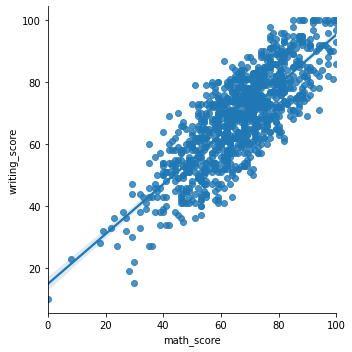

In [113]:
sns.lmplot(x='math_score', y='writing_score', data=student_perform)

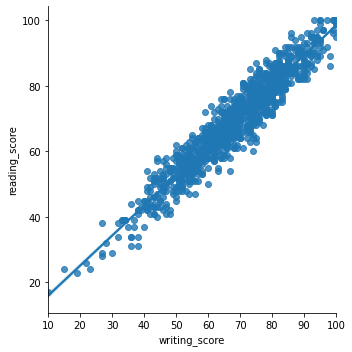

In [114]:
sns.lmplot(x='writing_score', y='reading_score', data=student_perform)

### Check normality of target variables

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d0a2da890>,
      dtype=object)

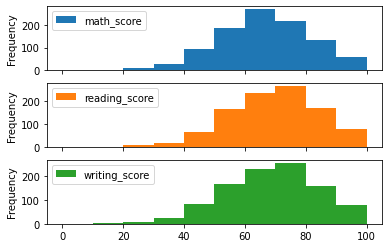

In [115]:
cols = [x for x in student_perform.columns if re.search('score', x)]
student_perform[cols].plot.hist(subplots=True, legend=True)

In [116]:
test_normality(student_perform, [x for x in student_perform.columns if re.search('score', x)], log=False)

,shapiro_stat,p_value
math_score,0.993,0.0
reading_score,0.993,0.0
writing_score,0.992,0.0


Shapiro-wilk p-value for each target variable less than 0.05 => the null hypothesis (target variable comes from normal distribution) must be rejected


Let's try to transofrm variables

In [117]:
test_normality(student_perform, [x for x in student_perform.columns if re.search('score', x)], log=False)

,shapiro_stat,p_value
math_score,0.993,0.0
reading_score,0.993,0.0
writing_score,0.992,0.0


Log-transformed  variables are still not normally distributed => Spearman (rank-based) correlation is more suitable then Pearson correlation

In [118]:
student_perform[cols].corr(method="spearman")

,math_score,reading_score,writing_score
math_score,1.000000,0.804064,0.778339
reading_score,0.804064,1.000000,0.948953
writing_score,0.778339,0.948953,1.000000


Linear models (one predictor): pre-requisites
    * Linear dependency (OK)
    * Normal distribution of residuals (looks appropriate on the scatter plots)
    * Homoscedasticity (looks appropriate on the scatter plots)

In [119]:
math_reading_mod = linear_model(student_perform, 'math_score', 'reading_score', log=True).\
rename(index={0: 'math_reading'})
math_writing_mod = linear_model(student_perform, 'math_score', 'writing_score', log=True).\
rename(index={0: 'math_writing'})
writing_reading_mod = linear_model(student_perform, 'writing_score', 'reading_score', log=True).\
rename(index={0: 'writing_reading'})
pd.concat([math_reading_mod, math_writing_mod, writing_reading_mod])

,slope,intercept,r_value,p_value
math_reading,0.636862,1.568256,0.790036,2.705337e-214
math_writing,0.696020,1.301704,0.796757,1.550755e-220
writing_reading,0.881615,0.517661,0.955381,0.000000e+00


Text(0.5, 1.0, 'Residuals distribution: math / reading scores')

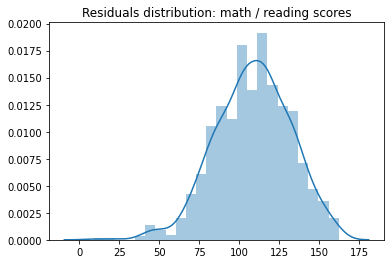

In [120]:
visualize_residuals(student_perform.math_score,
                    student_perform.reading_score,
                    math_reading_mod.intercept[0],
                    math_reading_mod.slope[0]).set_title("Residuals distribution: math / reading scores")

Text(0.5, 1.0, 'Residuals distribution: math / writing scores')

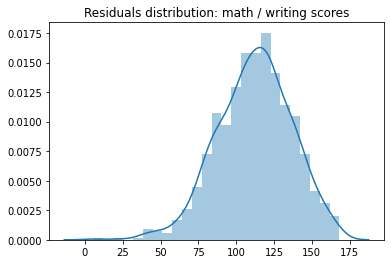

In [121]:
visualize_residuals(student_perform.math_score,
                    student_perform.writing_score,
                    math_writing_mod.intercept[0],
                    math_writing_mod.slope[0]).\
set_title("Residuals distribution: math / writing scores")

Text(0.5, 1.0, 'Residuals distribution: writing / reading scores')

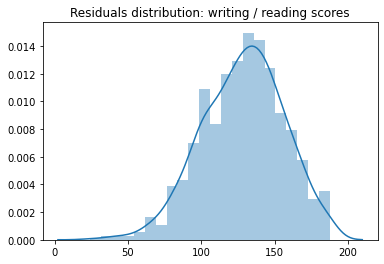

In [122]:
visualize_residuals(student_perform.writing_score,
                    student_perform.reading_score,
                    writing_reading_mod.intercept[0],
                    writing_reading_mod.slope[0]).\
set_title("Residuals distribution: writing / reading scores")

### Is the lunch type variable are equally distributed?

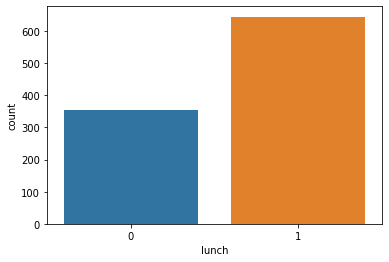

In [123]:
sns.countplot(x = 'lunch', data=student_perform)

In [124]:
stats.chisquare(student_perform.lunch.value_counts())

Power_divergenceResult(statistic=84.1, pvalue=4.703707096827142e-20)

Since p-value of chi-squared test < 0.05, the null hypothesis about the equal distribution can be rejected

It also can be proved by logistic regression intercept-only model

In [125]:
y, X = dmatrices('lunch ~ 1', data=student_perform, return_type='dataframe')
logit = sm.Logit(y, X)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.650487
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  lunch   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      999
Method:                           MLE   Df Model:                            0
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:               9.973e-12
Time:                        19:59:03   Log-Likelihood:                -650.49
converged:                       True   LL-Null:                       -650.49
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5971      0.066      9.036      0.000       0.468       0.727
==============================================================================
"""

### Test different log regression models

In [126]:
y, X = dmatrices('lunch ~ parental_level_of_education', data=student_perform, return_type='dataframe')
X.drop('Intercept', axis=1, inplace=True)
logit = sm.Logit(y, X)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.664478
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  lunch   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      999
Method:                           MLE   Df Model:                            0
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:                -0.02151
Time:                        19:59:04   Log-Likelihood:                -664.48
converged:                       True   LL-Null:                       -650.49
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
parental_level_of_education     0.1597      0.022      7.357      0.000       0.117       0.202
===============================================================================================
"""

In [127]:
y, X = dmatrices('lunch ~ race_ethnicity', data=student_perform, return_type='dataframe')
X.drop('Intercept', axis=1, inplace=True)
logit = sm.Logit(y, X)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.653926
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  lunch   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      999
Method:                           MLE   Df Model:                            0
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:               -0.005286
Time:                        19:59:04   Log-Likelihood:                -653.93
converged:                       True   LL-Null:                       -650.49
Covariance Type:            nonrobust   LLR p-value:                       nan
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
race_ethnicity     0.2354      0.027      8.561      0.000       0.181       0.289
==================================================================================
"""

In [128]:
y, X = dmatrices('lunch ~ parental_level_of_education : race_ethnicity', data=student_perform, return_type='dataframe')
X.drop('Intercept', axis=1, inplace=True)
logit = sm.Logit(y, X)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.664424
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  lunch   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      999
Method:                           MLE   Df Model:                            0
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:                -0.02143
Time:                        19:59:04   Log-Likelihood:                -664.42
converged:                       True   LL-Null:                       -650.49
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
parental_level_of_education:race_ethnicity     0.0668      0.009      7.231      0.000       0.049       0.085
==============================================================================================================
"""

In [129]:
y, X = dmatrices('lunch ~ parental_level_of_education * race_ethnicity', data=student_perform, return_type='dataframe')
X.drop('Intercept', axis=1, inplace=True)
logit = sm.Logit(y, X)
logit.fit().summary()

Optimization terminated successfully.
         Current function value: 0.651756
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  lunch   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 Apr 2020   Pseudo R-squ.:               -0.001951
Time:                        19:59:04   Log-Likelihood:                -651.76
converged:                       True   LL-Null:                       -650.49
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
parental_level_of_education                    0.0842      0.044      1.916      0.055      -0.002       0.170
race_ethnicity                                 0.2065      0.045      4.548      0.000       0.117       0.295
parental_level_of_education:race_ethnicity    -0.0190      0.022     -0.866      0.386      -0.062       0.024
==============================================================================================================
"""